<a href="https://colab.research.google.com/github/Kim-Jeong-Ju/AI_Modeling_Computer_Vision/blob/main/EfficientNet_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Drive Mount and Packages/Modules Importation**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import time
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

from collections import OrderedDict

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms

from torchsummary import summary

device = "cuda" if torch.cuda.is_available() else "cpu"
device

Mounted at /content/drive


'cuda'

# **※ Dataset Preparation**

###**CIFAR-10 Dataset** -- *32 X 32 pixels RGB Color images* with 10 class labels  
0(비행기), 1(자동차), 2(새), 3(고양이), 4(사슴), 5(개), 6(개구리), 7(말), 8(배), 9(트럭)

Files already downloaded and verified
Files already downloaded and verified
Train Data Length : 50000
# of Class Labels : [0 1 2 3 4 5 6 7 8 9]


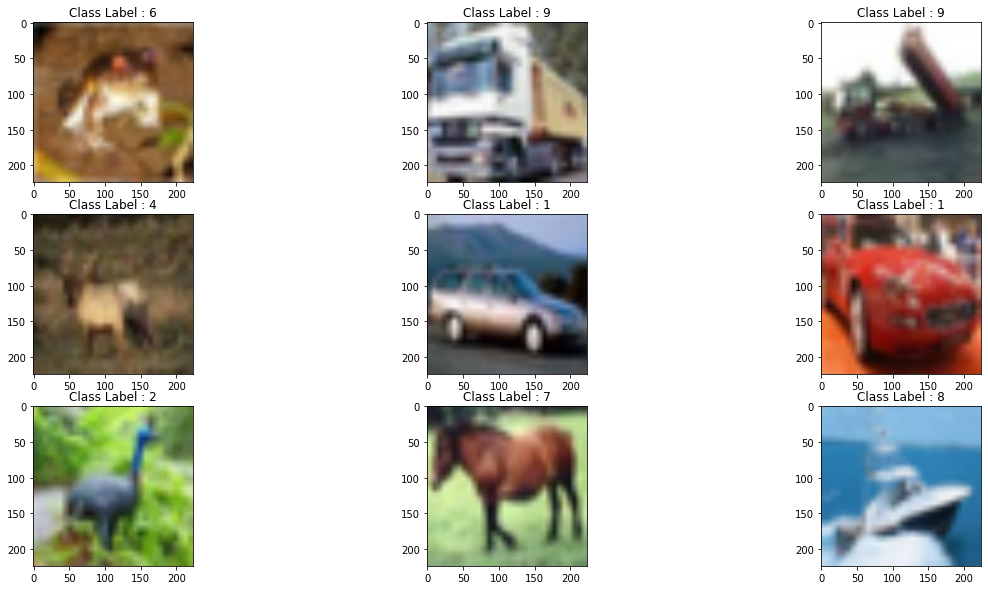

In [2]:
## Define Dataset Root Path and Transforms
root = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "AI Algorithm Modeling", "data")

apply_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


## Get CIFAR-10 Image Dataset
train_data = torchvision.datasets.CIFAR10(
    root=root,
    train=True,
    download=True,
    transform=apply_transform
)

test_data = torchvision.datasets.CIFAR10(
    root=root,
    train=False,
    download=True,
    transform=apply_transform
)


## Define Image Plot function
def sample_img_show(data, figsize=(20, 10)):
    fig = plt.figure(figsize=figsize)
    for i in range(9):
        image = data[i][0]
        ax = fig.add_subplot(3, 3, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.set_title(f"Class Label : {data[i][1]}")
    fig.show()


## Check CIFAR-10 Dataset
print(f"Train Data Length : {len(train_data.targets)}")
print(f"# of Class Labels : {np.unique(train_data.targets)}")
sample_img_show(data=train_data)

###**Training / Validation Dataset Split**

In [3]:
## Training / Validation Dataset Split with random_split
random_seed = 0
torch.manual_seed(random_seed)

valid_size = int(len(train_data) * 0.2)
train_size = len(train_data) - valid_size
train_data, valid_data = random_split(train_data, [train_size, valid_size])

print(f"Training Dataset : {len(train_data)}")
print(f"Validation Dataset : {len(valid_data)}")
print()

print(train_data[0][0].shape)

Training Dataset : 40000
Validation Dataset : 10000

torch.Size([3, 224, 224])


###**Definition of DataLoader Class**

In [4]:
## Definition of DataLoader Class
train_loader = DataLoader(dataset=train_data, batch_size=50, shuffle=True, drop_last=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=50, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset=test_data, batch_size=50, shuffle=False, drop_last=False)

loaders = {}
loaders["train"] = train_loader
loaders["valid"] = valid_loader
loaders["test"] = test_loader

print(f"Train Loader Length = {len(train_loader)},  Valid Loader Length = {len(valid_loader)},  Test Loader Length = {len(test_loader)}")

Train Loader Length = 800,  Valid Loader Length = 200,  Test Loader Length = 200


# <font color="#FF0000"> **※ EfficientNet v2 Model and Actuator Definition** </font>

### <font color="#FF0000"> **① Architecture of EfficientNet v2 Model with Original MBConv and Fused MBConv** </font>

In [5]:
## EfficientNet v2 Model with Original MBConv and Fused MBConv
class EfficientNetv2(nn.Module):
    def __init__(self, n_class=10):
        super().__init__()                                      # Input Image Tensor = 3 X 224 X 224
        
        self.input_block = nn.Sequential(                       # Advanced Input Block with ReLU6 = 12 X 112 X 112
            nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(12),
            nn.ReLU6()
        )

        self.A_fused_block = nn.Sequential()                    # ① A Fused MBConv Block - 1st Stage = 12 X 112 X 112
        for a in range(2):
            self.A_fused_block.add_module("A_Fused_MBConv_{}".format(a+1), fused_mb_conv(in_channels=12, out_channels=12, scale=1, stride=1, se_ratio=0.5))
        
        self.B_fused_block = nn.Sequential()                    # ② B Fused MBConv Block - 2nd Stage = 24 X 56 X 56
        for b in range(4):
            if b == 0:
                self.B_fused_block.add_module("B_Fused_MBConv_{}".format(b+1), fused_mb_conv(in_channels=12, out_channels=12, scale=4, stride=1, se_ratio=2))
            elif b == 3:
                self.B_fused_block.add_module("B_Fused_MBConv_{}".format(b+1), fused_mb_conv(in_channels=12, out_channels=24, scale=4, stride=2, se_ratio=2))
            else:
                self.B_fused_block.add_module("B_Fused_MBConv_{}".format(b+1), fused_mb_conv(in_channels=12, out_channels=12, scale=4, stride=1, se_ratio=2))
        
        self.C_fused_block = nn.Sequential()                    # ③ C Fused MBConv Block - 3rd Stage = 48 X 28 X 28
        for c in range(4):
            if c == 0:
                self.C_fused_block.add_module("C_Fused_MBConv_{}".format(c+1), fused_mb_conv(in_channels=24, out_channels=24, scale=4, stride=1, se_ratio=4))
            elif c == 3:
                self.C_fused_block.add_module("C_Fused_MBConv_{}".format(c+1), fused_mb_conv(in_channels=24, out_channels=48, scale=4, stride=2, se_ratio=4))
            else:
                self.C_fused_block.add_module("C_Fused_MBConv_{}".format(c+1), fused_mb_conv(in_channels=24, out_channels=24, scale=4, stride=1, se_ratio=4))

        self.D_origin_block = nn.Sequential()                   # ④ D Original MBConv Block - 4th Stage = 64 X 14 X 14
        for d in range(6):
            if d == 0:
                self.D_origin_block.add_module("D_Origin_MBConv_{}".format(d+1), original_mb_conv(in_channels=48, out_channels=48, scale=4, stride=1, se_ratio=4))
            elif d == 5:
                self.D_origin_block.add_module("D_Origin_MBConv_{}".format(d+1), original_mb_conv(in_channels=48, out_channels=64, scale=4, stride=2, se_ratio=4))
            else:
                self.D_origin_block.add_module("D_Origin_MBConv_{}".format(d+1), original_mb_conv(in_channels=48, out_channels=48, scale=4, stride=1, se_ratio=4))

        self.E_origin_block = nn.Sequential()                   # ⑤ E Original MBConv Block - 5th Stage = 128 X 14 X 14
        for e in range(9):
            if e == 0:
                self.E_origin_block.add_module("E_Origin_MBConv_{}".format(e+1), original_mb_conv(in_channels=64, out_channels=64, scale=6, stride=1, se_ratio=4))
            elif e == 8:
                self.E_origin_block.add_module("E_Origin_MBConv_{}".format(e+1), original_mb_conv(in_channels=64, out_channels=128, scale=6, stride=1, se_ratio=4))
            else:
                self.E_origin_block.add_module("E_Origin_MBConv_{}".format(e+1), original_mb_conv(in_channels=64, out_channels=64, scale=6, stride=1, se_ratio=4))

        self.F_origin_block = nn.Sequential()                   # ⑥ F Original MBConv Block - 6th Stage = 192 X 7 X 7
        for f in range(15):
            if f == 0:
                self.F_origin_block.add_module("F_Origin_MBConv_{}".format(f+1), original_mb_conv(in_channels=128, out_channels=128, scale=6, stride=1, se_ratio=4))
            elif f == 14:
                self.F_origin_block.add_module("F_Origin_MBConv_{}".format(f+1), original_mb_conv(in_channels=128, out_channels=192, scale=6, stride=2, se_ratio=4))
            else:
                self.F_origin_block.add_module("F_Origin_MBConv_{}".format(f+1), original_mb_conv(in_channels=128, out_channels=128, scale=6, stride=1, se_ratio=4))

        self.output_block = nn.Sequential(                      # Advanced Output Block with H-Swish and Drop-out = 10 Vectorize
            nn.Conv2d(in_channels=192, out_channels=512, kernel_size=1, stride=1),
            nn.BatchNorm2d(512),
            nn.Hardswish(),

            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),

            nn.Linear(in_features=512, out_features=128),
            nn.BatchNorm1d(128),
            nn.Hardswish(),
            nn.Dropout(p=0.25),

            nn.Linear(in_features=128, out_features=n_class)
        )

    def forward(self, input):
        temp1 = self.input_block(input)

        temp2 = self.A_fused_block(temp1)
        temp3 = self.B_fused_block(temp2)
        temp4 = self.C_fused_block(temp3)

        temp5 = self.D_origin_block(temp4)
        temp6 = self.E_origin_block(temp5)
        temp7 = self.F_origin_block(temp6)

        output = self.output_block(temp7)

        return output


## Advanced Fused MBConv in EfficientNet v2 Model
class fused_mb_conv(nn.Module):
    def __init__(self, in_channels, out_channels, scale, stride, se_ratio):
        super().__init__()

        self.mid_channels = int(in_channels * scale)
        
        self.input_conv = nn.Sequential(                                            # ① Advanced Input Conv Block of Fused MBConv with ReLU6
            nn.Conv2d(in_channels=in_channels, out_channels=self.mid_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(self.mid_channels),
            nn.ReLU6()
        )

        self.se_block = se_block(channels=self.mid_channels, ratio=se_ratio)        # ② Squeeze and Excitation Block of Fused MBConv with SiLU + Hard-Sigmoid

        self.output_conv = nn.Sequential(                                           # ③ Output Conv Block of Fused MBConv
            nn.Conv2d(in_channels=self.mid_channels, out_channels=out_channels, kernel_size=1, stride=1),
            nn.BatchNorm2d(out_channels)
        )

        self.adjust_channel = nn.Sequential(                                        # Adjustment Block for Different Channel Dimension with ReLU6
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU6()
        )

        self.adjust_size = nn.MaxPool2d(kernel_size=2, stride=2)                    # Adjustment Block for Different Feature Map Size with Max Pooling

    def forward(self, input):
        temp1 = self.input_conv(input)
        temp2 = self.se_block(temp1)
        temp3 = self.output_conv(temp2)

        if input.size(1) != temp3.size(1):
            input = self.adjust_channel(input)
        if input.size(2) != temp3.size(2) and input.size(3) != temp3.size(3):
            input = self.adjust_size(input)

        output = input + temp3                      # Skip-Connection with Residual Learning

        return output


## Advanced Original MBConv in EfficientNet v2 Model
class original_mb_conv(nn.Module):
    def __init__(self, in_channels, out_channels, scale, stride, se_ratio):
        super().__init__()

        self.mid_channels = int(in_channels * scale)
        
        self.input_conv = nn.Sequential(                                            # ① Advanced Input Conv Block of Original MBConv with ReLU6
            nn.Conv2d(in_channels=in_channels, out_channels=self.mid_channels, kernel_size=1, stride=1),
            nn.BatchNorm2d(self.mid_channels),
            nn.Hardswish()
        )

        self.depthwise = nn.Sequential(                                             # ② Advanced Depth-wise Convolutional Block of Original MBConv with ReLU6
            nn.Conv2d(in_channels=self.mid_channels, out_channels=self.mid_channels, kernel_size=3, stride=stride, padding=1, groups=self.mid_channels),
            nn.BatchNorm2d(self.mid_channels),
            nn.Hardswish()
        )

        self.se_block = se_block(channels=self.mid_channels, ratio=se_ratio)        # ③ Squeeze and Excitation Block of Original MBConv with SiLU + Hard-Sigmoid

        self.output_conv = nn.Sequential(                                           # ④ Output Conv Block of Original MBConv
            nn.Conv2d(in_channels=self.mid_channels, out_channels=out_channels, kernel_size=1, stride=1),
            nn.BatchNorm2d(out_channels)
        )

        self.adjust_channel = nn.Sequential(                                        # Adjustment Block for Different Channel Dimension with H-Swish
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1),
            nn.BatchNorm2d(out_channels),
            nn.Hardswish()
        )

        self.adjust_size = nn.MaxPool2d(kernel_size=2, stride=2)                    # Adjustment Block for Different Feature Map Size with Max Pooling

    def forward(self, input):
        temp1 = self.input_conv(input)
        temp2 = self.depthwise(temp1)
        temp3 = self.se_block(temp2)
        temp4 = self.output_conv(temp3)

        if input.size(1) != temp4.size(1):
            input = self.adjust_channel(input)
        if input.size(2) != temp4.size(2) and input.size(3) != temp4.size(3):
            input = self.adjust_size(input)

        output = input + temp4                      # Skip-Connection with Residual Learning

        return output


## Advanced SE Block for Squeeze and Excitation Process in EfficientNet v2 Model
class se_block(nn.Module):
    def __init__(self, channels, ratio=16):
        super().__init__()

        self.squeeze = nn.AdaptiveAvgPool2d(1)      # ① Squeeze Process of SE Algorithm : Global Average Pooling to 1X1 Feature map

        self.excitation = nn.Sequential(            # ② Excitation Process of SE Algorithm : Fully-Connected Operation with SiLU and Hard-Sigmoid
            nn.Flatten(),

            nn.Linear(in_features=channels, out_features=int(channels/ratio)),
            nn.SiLU(),
            nn.Linear(in_features=int(channels/ratio), out_features=channels),
            nn.Hardsigmoid(),
        )
    
    def forward(self, input):
        temp1 = self.squeeze(input)
        temp2 = self.excitation(temp1)

        contribute = temp2.view(temp2.size(0), temp2.size(1), 1, 1)
        output = torch.mul(input, contribute)

        return output


efficientnetv2_sample = EfficientNetv2(n_class=10).to(device)           # EfficientNet v2 Model for Sample Version
summary(efficientnetv2_sample, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 12, 112, 112]             336
       BatchNorm2d-2         [-1, 12, 112, 112]              24
             ReLU6-3         [-1, 12, 112, 112]               0
            Conv2d-4         [-1, 12, 112, 112]           1,308
       BatchNorm2d-5         [-1, 12, 112, 112]              24
             ReLU6-6         [-1, 12, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 12, 1, 1]               0
           Flatten-8                   [-1, 12]               0
            Linear-9                   [-1, 24]             312
             SiLU-10                   [-1, 24]               0
           Linear-11                   [-1, 12]             300
      Hardsigmoid-12                   [-1, 12]               0
         se_block-13         [-1, 12, 112, 112]               0
           Conv2d-14         [-1, 12, 1

### <font color="#FF0000"> **② Actuator(Trainer/Tester) Construction for EfficientNet v2** </font>

In [6]:
## EfficientNet v2 Actuator Definition
class EfficientNetv2_Actuator(nn.Module):
    def __init__(self, model, loaders, opt="sgd", lr=0.01, has_scheduler=False, device="cuda"):
        super().__init__()

        self.model = model
        self.loss = nn.CrossEntropyLoss()

        self.train_loader = loaders["train"]
        self.valid_loader = loaders["valid"]
        self.test_loader = loaders["test"]

        self._get_optimizer(opt=opt.lower(), lr=lr)
        self.has_scheduler = has_scheduler
        if self.has_scheduler:
            self._get_scheduler()

        self.device = device
    
    def _get_optimizer(self, opt="sgd", lr=0.01):
        if opt == "sgd":
            self.optimizer = torch.optim.SGD(params=self.model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0001)
        elif opt == "adagrad":
            self.optimizer = torch.optim.Adagrad(params=self.model.parameters(), lr=lr)
        elif opt == "adadelta":
            self.optimizer = torch.optim.Adadelta(params=self.model.parameters(), lr=lr)
        elif opt == "rmsprop":
            self.optimizer = torch.optim.RMSprop(params=self.model.parameters(), lr=lr)
        elif opt == "adam":
            self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=lr)
        else:
            raise ValueError(f"Inputted Optimizer {opt} is not Supported")
    
    def _get_scheduler(self):
        self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer=self.optimizer, step_size=10, gamma=0.3, verbose=True)    # 학습의 총 epoch에서 step_size마다 gamma의 비율로 learning rate를 순차적으로 줄임
        # self.scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=self.optimizer, lr_lambda=lambda epoch: 0.95**epoch)   # 학습 도중 lr_lambda에 정의한 function에 의해 learning rate을 순차적으로 줄임
    
    def train_and_valid(self, max_epochs=10, disp_epochs=1):
        print("========== Train and Valid Start ==========")
        start_time = time.time()

        history = {"Train_Loss" : [], "Train_Acc" : [], "Valid_Loss" : [], "Valid_Acc" : []}

        for epoch in tqdm(range(max_epochs), desc="Training Process..."):
            train_loss, train_acc = self._train_epoch()
            valid_loss, valid_acc = self._valid_epoch()

            history["Train_Loss"].append(train_loss)
            history["Train_Acc"].append(train_acc)
            history["Valid_Loss"].append(valid_loss)
            history["Valid_Acc"].append(valid_acc)

            if self.has_scheduler:
                self.scheduler.step()
            
            if epoch % disp_epochs == 0:
                print(f"{epoch+1}/{max_epochs} Epoch ==> Train Loss : {train_loss:>6f}, Train Acc : {train_acc:>6f}, Valid Loss : {valid_loss:>6f}, Valid Acc : {valid_acc:>6f}, Time : {time.time() - start_time:>3f}")
                start_time = time.time()
        
        self.plot_history(history)
    
    def _train_epoch(self):
        train_epoch_loss, train_epoch_acc = 0, 0
        self.model.train()

        for (a, b) in self.train_loader:
            a = a.to(device=self.device)
            b = b.to(device=self.device)

            b_hat = self.model(a)
            loss = self.loss(b_hat, b)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            train_epoch_loss += loss.to("cpu").item()
            train_epoch_acc += (b_hat.argmax(1) == b).type(torch.float).to("cpu").mean().item()
        
        train_epoch_loss /= len(self.train_loader)
        train_epoch_acc /= len(self.train_loader)

        return train_epoch_loss, train_epoch_acc
    
    def _valid_epoch(self):
        valid_epoch_loss, valid_epoch_acc = 0, 0
        self.model.eval()

        with torch.no_grad():
            for (a, b) in self.valid_loader:
                a = a.to(device=self.device)
                b = b.to(device=self.device)

                b_hat = self.model(a)
                loss = self.loss(b_hat, b)

                valid_epoch_loss += loss.to("cpu").item()
                valid_epoch_acc += (b_hat.argmax(1) == b).type(torch.float).to("cpu").mean().item()
        
        valid_epoch_loss /= len(self.valid_loader)
        valid_epoch_acc /= len(self.valid_loader)

        return valid_epoch_loss, valid_epoch_acc
    
    def plot_history(self, history):
        fig = plt.figure(figsize=(20, 10))

        ax = fig.add_subplot(1, 2, 1)
        ax.plot(history["Train_Loss"], color="red", label="Train Loss")
        ax.plot(history["Valid_Loss"], color="orange", label="Valid Loss")
        ax.set_title("Loss")
        ax.legend()

        ax = fig.add_subplot(1, 2, 2)
        ax.plot(history["Train_Acc"], color="red", label="Train Accuracy")
        ax.plot(history["Valid_Acc"], color="orange", label="Valid Accuracy")
        ax.set_title("Accuracy")
        ax.legend()

        fig.show()
    
    def test(self):
        print("========== Test Start ==========")
        start_time = time.time()

        test_epoch_loss, test_epoch_acc = 0, 0
        self.model.eval()

        with torch.no_grad():
            for (a, b) in self.test_loader:
                a = a.to(device=self.device)
                b = b.to(device=self.device)

                b_hat = self.model(a)
                loss = self.loss(b_hat, b)

                test_epoch_loss += loss.to("cpu").item()
                test_epoch_acc += (b_hat.argmax(1) == b).type(torch.float).to("cpu").mean().item()
        
        test_epoch_loss /= len(self.test_loader)
        test_epoch_acc /= len(self.test_loader)

        print(f"Test loss: {test_epoch_loss:>6f}, Test acc: {test_epoch_acc:>3f}, Test time : {time.time() - start_time:>3f}")

# <font color="#FFBB00"> **※ Training / Validating / Testing** </font>

========== Train and Valid Start ==========


Training Process...:   5%|▌         | 1/20 [09:12<2:55:06, 552.97s/it]

1/20 Epoch ==> Train Loss : 1.516754, Train Acc : 0.430000, Valid Loss : 1.281605, Valid Acc : 0.533700, Time : 552.974513


Training Process...:  10%|█         | 2/20 [18:27<2:46:08, 553.80s/it]

2/20 Epoch ==> Train Loss : 1.007395, Train Acc : 0.640500, Valid Loss : 0.854525, Valid Acc : 0.704700, Time : 554.387197


Training Process...:  15%|█▌        | 3/20 [27:40<2:36:48, 553.42s/it]

3/20 Epoch ==> Train Loss : 0.752519, Train Acc : 0.739975, Valid Loss : 0.736325, Valid Acc : 0.748700, Time : 552.958565


Training Process...:  20%|██        | 4/20 [36:52<2:27:25, 552.87s/it]

4/20 Epoch ==> Train Loss : 0.601995, Train Acc : 0.792950, Valid Loss : 0.601754, Valid Acc : 0.792700, Time : 552.043743


Training Process...:  25%|██▌       | 5/20 [46:04<2:18:10, 552.72s/it]

5/20 Epoch ==> Train Loss : 0.499626, Train Acc : 0.829400, Valid Loss : 0.554606, Valid Acc : 0.808500, Time : 552.434645


Training Process...:  30%|███       | 6/20 [55:16<2:08:53, 552.42s/it]

6/20 Epoch ==> Train Loss : 0.426264, Train Acc : 0.854850, Valid Loss : 0.522904, Valid Acc : 0.819800, Time : 551.831793


Training Process...:  35%|███▌      | 7/20 [1:04:28<1:59:37, 552.13s/it]

7/20 Epoch ==> Train Loss : 0.354037, Train Acc : 0.878450, Valid Loss : 0.473289, Valid Acc : 0.839800, Time : 551.538656


Training Process...:  40%|████      | 8/20 [1:13:39<1:50:22, 551.89s/it]

8/20 Epoch ==> Train Loss : 0.303974, Train Acc : 0.895825, Valid Loss : 0.487435, Valid Acc : 0.840600, Time : 551.367655


Training Process...:  45%|████▌     | 9/20 [1:22:51<1:41:10, 551.88s/it]

9/20 Epoch ==> Train Loss : 0.249550, Train Acc : 0.915000, Valid Loss : 0.459284, Valid Acc : 0.852800, Time : 551.853385


Training Process...:  50%|█████     | 10/20 [1:32:02<1:31:57, 551.72s/it]

10/20 Epoch ==> Train Loss : 0.212305, Train Acc : 0.926175, Valid Loss : 0.475236, Valid Acc : 0.850400, Time : 551.365501


Training Process...:  55%|█████▌    | 11/20 [1:41:13<1:22:43, 551.48s/it]

11/20 Epoch ==> Train Loss : 0.175933, Train Acc : 0.939500, Valid Loss : 0.502604, Valid Acc : 0.850100, Time : 550.929792


Training Process...:  60%|██████    | 12/20 [1:50:24<1:13:31, 551.43s/it]

12/20 Epoch ==> Train Loss : 0.150374, Train Acc : 0.947350, Valid Loss : 0.499624, Valid Acc : 0.853300, Time : 551.313130


Training Process...:  65%|██████▌   | 13/20 [1:59:36<1:04:20, 551.57s/it]

13/20 Epoch ==> Train Loss : 0.126862, Train Acc : 0.956150, Valid Loss : 0.519605, Valid Acc : 0.852200, Time : 551.895771


Training Process...:  70%|███████   | 14/20 [2:08:48<55:09, 551.61s/it]  

14/20 Epoch ==> Train Loss : 0.114929, Train Acc : 0.960325, Valid Loss : 0.519384, Valid Acc : 0.852800, Time : 551.712215


Training Process...:  75%|███████▌  | 15/20 [2:17:59<45:56, 551.28s/it]

15/20 Epoch ==> Train Loss : 0.101510, Train Acc : 0.965225, Valid Loss : 0.542636, Valid Acc : 0.853500, Time : 550.516227


Training Process...:  80%|████████  | 16/20 [2:27:10<36:44, 551.20s/it]

16/20 Epoch ==> Train Loss : 0.088929, Train Acc : 0.969925, Valid Loss : 0.574967, Valid Acc : 0.851400, Time : 550.999308


Training Process...:  85%|████████▌ | 17/20 [2:36:21<27:33, 551.12s/it]

17/20 Epoch ==> Train Loss : 0.094643, Train Acc : 0.967075, Valid Loss : 0.525615, Valid Acc : 0.859800, Time : 550.953600


Training Process...:  90%|█████████ | 18/20 [2:45:31<18:22, 551.06s/it]

18/20 Epoch ==> Train Loss : 0.075095, Train Acc : 0.973925, Valid Loss : 0.549356, Valid Acc : 0.862000, Time : 550.916703


Training Process...:  95%|█████████▌| 19/20 [2:54:42<09:10, 550.92s/it]

19/20 Epoch ==> Train Loss : 0.076537, Train Acc : 0.972950, Valid Loss : 0.583532, Valid Acc : 0.858400, Time : 550.578130


Training Process...: 100%|██████████| 20/20 [3:03:53<00:00, 551.66s/it]

20/20 Epoch ==> Train Loss : 0.068313, Train Acc : 0.977225, Valid Loss : 0.574516, Valid Acc : 0.857800, Time : 550.720981
Total Training Time : 11033.352017
========== Test Start ==========


Test loss: 0.608550, Test acc: 0.854300, Test time : 40.316541


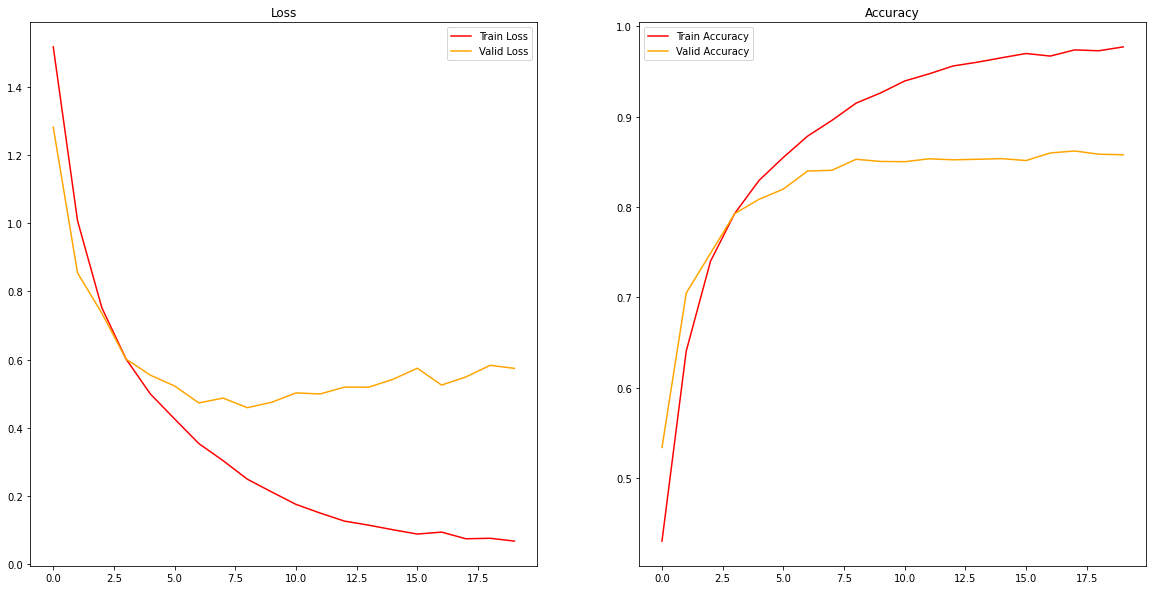

In [7]:
## Training and Validating and Testing for CIFAR-10 by EfficientNet v2
device = "cuda"
efficientnetv2_model = EfficientNetv2(n_class=10).to(device)                        # EfficientNet v2 Model for Training Version
efficientnetv2_actuator = EfficientNetv2_Actuator(model=efficientnetv2_model, loaders=loaders, opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)

start_time = time.time()
efficientnetv2_actuator.train_and_valid(max_epochs=20, disp_epochs=1)
print(f"Total Training Time : {time.time() - start_time:>3f}")

efficientnetv2_actuator.test()                                                      # EfficientNet v2 Model for Testing Version

# <font color="#2F9D27"> **※ EfficientNet v2 Model Save and Load** </font>

### <font color="#2F9D27"> **① EfficientNet v2 Model Save based on Train/Valid History** </font>

In [8]:
## EfficientNet v2 Model Save
for param_tensor in efficientnetv2_model.state_dict():
    print(f"{param_tensor} : \t {efficientnetv2_model.state_dict()[param_tensor].size()}")   # EfficientNet v2 model의 state dictionary 출력 -> 각 layer에서의 parameter들

model_dir = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "AI Algorithm Modeling", "model")
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.save(efficientnetv2_model.state_dict(), os.path.join(model_dir, "EfficientNet_v2.pth"))

input_block.0.weight : 	 torch.Size([12, 3, 3, 3])
input_block.0.bias : 	 torch.Size([12])
input_block.1.weight : 	 torch.Size([12])
input_block.1.bias : 	 torch.Size([12])
input_block.1.running_mean : 	 torch.Size([12])
input_block.1.running_var : 	 torch.Size([12])
input_block.1.num_batches_tracked : 	 torch.Size([])
A_fused_block.A_Fused_MBConv_1.input_conv.0.weight : 	 torch.Size([12, 12, 3, 3])
A_fused_block.A_Fused_MBConv_1.input_conv.0.bias : 	 torch.Size([12])
A_fused_block.A_Fused_MBConv_1.input_conv.1.weight : 	 torch.Size([12])
A_fused_block.A_Fused_MBConv_1.input_conv.1.bias : 	 torch.Size([12])
A_fused_block.A_Fused_MBConv_1.input_conv.1.running_mean : 	 torch.Size([12])
A_fused_block.A_Fused_MBConv_1.input_conv.1.running_var : 	 torch.Size([12])
A_fused_block.A_Fused_MBConv_1.input_conv.1.num_batches_tracked : 	 torch.Size([])
A_fused_block.A_Fused_MBConv_1.se_block.excitation.1.weight : 	 torch.Size([24, 12])
A_fused_block.A_Fused_MBConv_1.se_block.excitation.1.bias : 	 

### <font color="#2F9D27"> **② EfficientNet v2 Model Load and Performance Estimation** </font>

In [9]:
## EfficientNet v2 Model Load
device = "cuda"

print("========== EfficientNet v2 Test without Load ==========")    # ① 먼저 학습하지 않은 상태로 Actuator를 통해 Test dataset 성능 측정
efficientnetv2 = EfficientNetv2(n_class=10).to(device)
efficientnetv2_actuator = EfficientNetv2_Actuator(model=efficientnetv2, loaders=loaders, opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)
efficientnetv2_actuator.test()

model_path = os.path.join(model_dir, "EfficientNet_v2.pth")
print(model_path)
print()

print("========== EfficientNet v2 Test with Load ==========")       # ② 이전에 학습된 Model의 parameter들을 Load한 후, Test dataset 성능 측정
efficientnetv2.load_state_dict(torch.load(model_path))
efficientnetv2.eval()

efficientnetv2_loaded_actuator = EfficientNetv2_Actuator(model=efficientnetv2, loaders=loaders, opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)
efficientnetv2_loaded_actuator.test()

========== EfficientNet v2 Test without Load ==========
========== Test Start ==========
Test loss: 2.303719, Test acc: 0.100000, Test time : 40.274913
/content/drive/MyDrive/Colab Notebooks/AI Algorithm Modeling/model/EfficientNet_v2.pth

========== EfficientNet v2 Test with Load ==========
========== Test Start ==========
Test loss: 0.608550, Test acc: 0.854300, Test time : 40.271380
